# Customer Segmentation

### Explore and identify different segments present in the customer transaction data.

#### Output results: List of segments identified and user ids belonging to that segment

Database contains information of purchase transaction of United Kingdom(maybe) based E-commerce company. Do customer segmentation based on their purchase trasactions.

Total 8 variables as follow:

1. user_id 				- Unique identifier of a user.
2. trans_id 		    - Unique identifier of a transaction. If the same, then all those products are bought together.
3. trans_time		    - Time at which the transaction is performed
4. item_code			- Unique identifier of the product purchased
5. description		    - Simple description of the product purchased
6. quantity	            - Quantity of the product purchased in the transaction
7. unit_price			- Price per each unit of the product
8. country			    - Country from which the purchase is made.

# Modules Loading

In [1]:
# Import modules
import numpy as np
import pandas as pd
from dateutil import tz
import datetime, nltk, warnings
from datetime import datetime, timedelta
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# setting seaborn default for plots
sns.set() 

# Data Preparation

In [2]:
# Import Dataset
df = pd.read_csv('/root/Keyur Khant/Study/Others/Argoid/Assignments/transaction_data.csv')

In [3]:
# Shape and top 5 row of dataframe
print("Shape of Dataset:", df.shape)
df.head()

Shape of Dataset: (1083818, 8)


,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


In [4]:
# Change the column names
df.rename(index=str, columns={'UserId': 'user_id',
                              'TransactionId' : 'trans_id',
                              'TransactionTime' : 'trans_time',
                              'ItemCode' : 'item_code',
                              'ItemDescription' : 'description',
                              'NumberOfItemsPurchased' : 'quantity',
                              'CostPerItem' : 'unit_price',
                              'Country' : 'country'}, inplace=True)

In [5]:
df.head()

,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


# Data Cleaning

In [6]:
# Information about data columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1083818 entries, 0 to 1083817
Data columns (total 8 columns):
user_id        1083818 non-null int64
trans_id       1083818 non-null int64
trans_time     1083818 non-null object
item_code      1083818 non-null int64
description    1080910 non-null object
quantity       1083818 non-null int64
unit_price     1083818 non-null float64
country        1083818 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 74.4+ MB


### Check Missing Values

There are missing values in user_id with -1 value. So replace it to NULL

In [7]:
# Replace -1 to NULL in user_id
df['user_id'] = df['user_id'].replace(to_replace = -1, value = np.nan) 

In [8]:
# Show all null value count with percentage and column type
tab = pd.DataFrame(df.dtypes).T.rename(index={0:'Column Type'})
tab = tab.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Null Values'}))
tab = tab.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Null Values in %'}))

print("Dataframe Dimensions: ", df.shape)
tab

Dataframe Dimensions:  (1083818, 8)


,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country
Column Type,float64,int64,object,int64,object,int64,float64,object
Null Values,270160,0,0,0,2908,0,0,0
Null Values in %,24.9267,0,0,0,0.268311,0,0,0


Looking at NULL values we can note that 24.93% (~25%) of the entries are not belonging to any user. These entries are useless. So, we can simply remove it.

In [9]:
# Remove NULL values
df.dropna(axis = 0, subset = ['user_id'], inplace = True)

# Again check is any NULL value remain
tab = pd.DataFrame(df.dtypes).T.rename(index={0:'Column Type'})
tab = tab.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Null Values'}))
tab = tab.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Null Values in %'}))

print('Dataframe Dimensions: ', df.shape)
tab

Dataframe Dimensions:  (813658, 8)


,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country
Column Type,float64,int64,object,int64,object,int64,float64,object
Null Values,0,0,0,0,0,0,0,0
Null Values in %,0,0,0,0,0,0,0,0


### Check Duplicate Entries

In [10]:
# Is any entries are duplicate or not?
print('Total Duplicate Entries: ' , df.duplicated().sum())
print('Percentage of Duplication: ' , (df.duplicated().sum() / len(df) * 100).round(2) , '%')

Total Duplicate Entries:  412089
Percentage of Duplication:  50.65 %


Above result shows that more than 50% of the data are duplicated. So take first and remove all its duplicates.

In [11]:
# Remove duplicate data
df.drop_duplicates(inplace = True)

In [12]:
print('Dataframe Dimensions: ', df.shape)
df.head()

Dataframe Dimensions:  (401569, 8)


,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country
0,278166.0,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701.0,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099.0,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478.0,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
5,285957.0,6307136,Fri Jan 11 09:50:00 IST 2019,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom


### Convert time(object) to datetime

In [13]:
# Covert Object type of trans_time into datetime format
df['trans_time'] = pd.to_datetime(df['trans_time'])

In [14]:
# Here you can see that date in UTC format.
df.head()

,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country
0,278166.0,6355745,2019-02-02 12:50:00+05:30,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701.0,6283376,2018-12-26 09:06:00+05:30,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099.0,6385599,2019-02-15 09:45:00+05:30,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478.0,6044973,2018-06-22 07:14:00+05:30,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
5,285957.0,6307136,2019-01-11 09:50:00+05:30,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom


In [15]:
#Convert to IST by adding 5:30
df['trans_time'] = df['trans_time'] + timedelta(hours = 5, minutes = 30)

In [16]:
# Check the date variations in the DataFrame
print("Min Date: {} \t Max Date: {}".format(df['trans_time'].min(), df['trans_time'].max()))

Min Date: 2018-02-12 09:56:00+05:30 	 Max Date: 2028-02-18 18:49:00+05:30


Here some date has year 2028. It may be error in entry instred of 2018.

In [17]:
# Check how many entry has year 2028.
temp = df[df['trans_time'].dt.year == 2028]
print("Number of Entry with wrong year(2028) :" , len(temp))
temp.head()

Number of Entry with wrong year(2028) : 1117


,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country
241,366870.0,5912049,2028-02-18 11:27:00+05:30,473613,PLASTERS IN TIN SKULLS,36,2.28,United Kingdom
602,369411.0,5914106,2028-02-18 17:09:00+05:30,481278,HERB MARKER PARSLEY,3,0.90,United Kingdom
1070,259287.0,5913886,2028-02-18 16:27:00+05:30,477246,ALARM CLOCK BAKELIKE GREEN,12,5.18,Iceland
1610,267708.0,5913864,2028-02-18 16:11:00+05:30,458346,EIGHT PIECE DINOSAUR SET,9,1.73,United Kingdom
1792,315504.0,5913688,2028-02-18 14:50:00+05:30,453432,RETROSPOT CIGAR BOX MATCHES,12,1.73,United Kingdom


In [18]:
# Check same month and date for year 2018.
temp2 = df[(df['trans_time'].dt.year == 2018) & (df['trans_time'].dt.month == 2) & (df['trans_time'].dt.day == 18)]
print("Number of Entries with date 18-02-2018 is:" , len(temp2))

Number of Entries with date 18-02-2018 is: 0


Here you notice that only 18/02/2018 has no transaction and all the entries with year 2028 has date 18/02. So, it is confirmed that there is year 2018 in place of 2028 and all other will remain same.

In [19]:
# Replace 2028 to 2018
df['trans_time'] = df['trans_time'].mask(df['trans_time'].dt.year == 2028,df['trans_time'] + pd.offsets.DateOffset(year=2018))

/root/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:837: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


In [20]:
df.head()

,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country
0,278166.0,6355745,2019-02-02 18:20:00+05:30,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701.0,6283376,2018-12-26 14:36:00+05:30,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099.0,6385599,2019-02-15 15:15:00+05:30,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478.0,6044973,2018-06-22 12:44:00+05:30,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
5,285957.0,6307136,2019-01-11 15:20:00+05:30,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom


In [21]:
# Check the date variations in the DataFrame
print("Final Interval of Dates.........")
print("Min Date: {} \t Max Date: {}".format(df['trans_time'].min(), df['trans_time'].max()))

Final Interval of Dates.........
Min Date: 2018-02-12 09:56:00+05:30 	 Max Date: 2019-02-20 14:20:00+05:30


# Variables Exploring & Cleaning

### Changes in item_code column 

In [22]:
print("Number of Rows with -1 in item_code: " , len(df[df["item_code"] == -1]))
df[df['item_code'] == -1].head()

Number of Rows with -1 in item_code:  1781


,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country
154,266301.0,5970085,2018-04-14 17:06:00+05:30,-1,POSTAGE,9,24.84,France
251,266028.0,5969843,2018-04-14 14:57:00+05:30,-1,POSTAGE,21,24.84,Germany
993,287574.0,6190756,2018-10-21 15:57:00+05:30,-1,Discount,-3,88.32,United Kingdom
1261,264243.0,6153851,2018-09-19 13:52:00+05:30,-1,POSTAGE,6,24.84,France
1773,268632.0,6026867,2018-06-09 13:06:00+05:30,-1,POSTAGE,6,38.64,Portugal


In [23]:
# These are unique value of description according to item_code
df[df['item_code'] == -1]['description'].unique()

array(['POSTAGE', 'Discount', 'Manual', 'Bank Charges', 'CRUK Commission',
       'DOTCOM POSTAGE', 'PADS TO MATCH ALL CUSHIONS'], dtype=object)

Here Item_code is -1 but if we notice description has different charges, not items. So replace item_code which unique value for now.

In [24]:
df.loc[df['description'] == 'POSTAGE' , 'item_code'] = 'POST' # For POSTAGE
df.loc[df['description'] == 'Discount', 'item_code'] = 'D' # For Discount
df.loc[df['description'] == 'Manual', 'item_code'] = "M" # For Manual
df.loc[df['description'] == 'Bank Charges', 'item_code'] = 'BANK CHARGES' # For BANK CHARGES
df.loc[df['description'] == 'CRUK Commission', 'item_code'] = "C2" # For CRUK Commission
df.loc[df['description'] == 'DOTCOM POSTAGE', 'item_code'] = 'DOT' # For DOTCOM POSTAGE
df.loc[df['description'] == 'PADS TO MATCH ALL CUSHIONS', 'item_code'] = "PADS" # For PADS TO MATCH ALL CUSHIONS

In [25]:
print("Remaining item_code with -1 value: " , len(df[df['item_code'] == '-1']))

Remaining item_code with -1 value:  0


### Remove Quantity with Negetive values 

In [26]:
print("Number of Rows with -ve Quantity: " , len(df[df["quantity"] <= 0]))
df[df["quantity"] <= 0].head()

Number of Rows with -ve Quantity:  8871


,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country
69,300909.0,6015757,2018-05-29 19:44:00+05:30,466452,FOUR HOOK WHITE LOVEBIRDS,-3,2.90,United Kingdom
135,319683.0,6036228,2018-06-16 13:58:00+05:30,470883,REGENCY CAKESTAND 3 TIER,-24,17.60,United Kingdom
329,321531.0,5925150,2018-02-24 16:35:00+05:30,446418,VICTORIAN SEWING BOX LARGE,-3,15.12,United Kingdom
330,260715.0,6165940,2018-09-30 13:56:00+05:30,488061,TREASURE TIN GYMKHANA DESIGN,-3,2.88,Australia
353,274869.0,6004240,2018-05-19 15:05:00+05:30,470883,REGENCY CAKESTAND 3 TIER,-15,15.12,United Kingdom


You can notice that in above dataframe all entries(total 8871) with negetive value of quantity. This can't be possible.

It may be cancellation of order. So, I cross check if order indicating same quantity with positive value with same discription.

In [27]:
df_check = df[df['quantity'] <= 0][['user_id','quantity','item_code','description','unit_price']]
for index, col in  df_check.iterrows():
    if df[(df['user_id'] == col[0]) & (df['quantity'] == -col[1]) & (df['description'] == col[3])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

user_id                            300909
quantity                               -3
item_code                          466452
description    FOUR HOOK  WHITE LOVEBIRDS
unit_price                            2.9
Name: 69, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


I find that the hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made before.

So, make new column named Quantity Canceled. 

For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before February 2018. Below, I make a census of the cancel orders and check for the existence of counterparts

In [28]:
df_cleaned = df.copy(deep = True)
df_cleaned['quantity_canceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['quantity'] > 0) or col['description'] == 'Discount': continue        
    df_test = df[(df['user_id'] == col['user_id']) &
                 (df['item_code']  == col['item_code']) & 
                 (df['trans_time'] < col['trans_time']) & 
                 (df['quantity'] > 0)].copy()
    
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'quantity_canceled'] = -col['quantity']
        entry_to_remove.append(index)        
    
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['quantity'] < -col['quantity']: continue
            df_cleaned.loc[ind, 'quantity_canceled'] = -col['quantity']
            entry_to_remove.append(index) 
            break 

In [29]:
print("entry_to_remove: " , len(entry_to_remove))
print("doubtfull_entry: " , len(doubtfull_entry))

entry_to_remove:  7537
doubtfull_entry:  1208


In the above function, I checked the two cases:

1. a cancel order exists which are doubtful enries
2. there's at least one counterpart with the exact same quantity which we have confirmed to remove

In [30]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

There are also some entries which has negetive quality value and still remain which correspond to cancellation.

In [31]:
remaining_entries = df_cleaned[(df_cleaned['quantity'] < 0) & (df_cleaned['item_code'] != 'D')]
print("Number of entries with cancellation: " , remaining_entries.shape[0])
remaining_entries.head()

Number of entries with cancellation:  49


,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country,quantity_canceled
4799,275373.0,6272431,2018-12-21 14:26:00+05:30,469476,CHARLOTTE BAG PINK POLKADOT,-39,1.18,United Kingdom,0
18567,310968.0,6250552,2018-12-08 12:57:00+05:30,483147,SPACEBOY BABY GIFT SET,-9,23.40,United Kingdom,0
38795,305403.0,6244876,2018-12-04 11:46:00+05:30,458703,RED RETROSPOT CAKE STAND,-24,13.74,United Kingdom,0
41730,275373.0,6272431,2018-12-21 14:26:00+05:30,435183,STRAWBERRY CHARLOTTE BAG,-54,1.18,United Kingdom,0
44362,308448.0,6231137,2018-11-24 19:34:00+05:30,487179,JUMBO BAG APPLES,-42,2.88,United Kingdom,0


Note: I take this cancellation because for further analysis.

It will not usefull for clustering.

### Check of Unit_Price

In [32]:
# Describe unit_price
df_cleaned['unit_price'].describe().round(2)

count     392824.00
mean           8.66
std         2706.62
min            0.00
25%            1.73
50%            2.70
75%            5.18
max      1696285.44
Name: unit_price, dtype: float64

This discription shows that minimum value of unit_price is 0. (is that possible?)

But some times E-Commmerce company gives items for free with other items or in the sales. So, we can't confirm about this entries.

### Customer and Product relations

In [33]:
# What are the number of users and products in these entries ?
pd.DataFrame([{'Products': len(df_cleaned['item_code'].value_counts()),    
               'Transactions': len(df_cleaned['trans_id'].value_counts()),
               'Customers': len(df_cleaned['user_id'].value_counts()),  
              }], columns = ['Products', 'Transactions', 'Customers'], index = ['Quantity'])

,Products,Transactions,Customers
Quantity,3200,18632,4339


It can be seen that the data concern 4339 users and that they bought 3200 different products. The total number of transactions carried out is 18632.

In [34]:
# The number of products purchased in every transaction
temp = df_cleaned.groupby(by=['user_id', 'trans_id'], as_index=False)['trans_time'].count()
products_per_basket = temp.rename(columns = {'trans_time':'Number of Products'})
products_per_basket[:10].sort_values('user_id')

,user_id,trans_id,Number of Products
0,259266.0,5955741,1
1,259287.0,5913886,31
2,259287.0,5964607,29
3,259287.0,6041442,24
4,259287.0,6118211,18
5,259287.0,6182352,22
6,259287.0,6308621,47
7,259287.0,6392980,11
8,259308.0,5932498,17
9,259308.0,5961978,6


In [36]:
len(products_per_basket)

18632

Two things we can derive from above:

1. Users who only came once and only purchased one product (e.g. 259266)
2. Frequent users that buy a large number of items at each order (e.g. 259287)

### Unit Price and Add Total Price Column

I create a new variable that indicates the total price of every purchase:

In [35]:
# Add new Column for total price
df_cleaned['total_price'] = df_cleaned['unit_price'] * (df_cleaned['quantity'] - df_cleaned['quantity_canceled'])
df_cleaned.sort_values('user_id')[:5]

,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country,quantity_canceled,total_price
528376,259266.0,5955741,2018-04-01 11:31:00+05:30,486486,MEDIUM CERAMIC TOP STORAGE JAR,222645,1.44,United Kingdom,222645,0.00
595676,259287.0,6308621,2019-01-12 13:55:00+05:30,435099,WOODLAND CHARLOTTE BAG,30,1.18,Iceland,0,35.40
1070,259287.0,5913886,2018-02-18 16:27:00+05:30,477246,ALARM CLOCK BAKELIKE GREEN,12,5.18,Iceland,0,62.16
423220,259287.0,6041442,2018-06-19 12:13:00+05:30,433965,RED RETROSPOT PURSE,18,4.08,Iceland,0,73.44
512603,259287.0,6308621,2019-01-12 13:55:00+05:30,469875,AIRLINE BAG VINTAGE JET SET BROWN,24,5.87,Iceland,0,140.88


Here, we know that each rows/entry in dataframe shows price and other characteristics for single kind of product. So, orders are split into different rows.(Same Trasaction ID).

So, collect all purchases made during one transaction and get total order price.

In [37]:
# Generalize total Cart price on same Transaction
temp = df_cleaned.groupby(by=['user_id', 'trans_id'], as_index=False)['total_price'].sum()
cart_price = temp.rename(columns = {'total_price':'cart_price'})

In [38]:
# Now join Transaction Date with this new cart_price
df_cleaned['trans_time'] = df_cleaned['trans_time'].astype('int64')

# If all orders are in same time period, then take mean of it.
temp = df_cleaned.groupby(by=['user_id', 'trans_id'], as_index=False)['trans_time'].mean()

cart_price.loc[:, 'trans_time'] = pd.to_datetime(temp['trans_time'])

In [39]:
df_cleaned['trans_time'] = pd.to_datetime(df_cleaned['trans_time'])

In [42]:
df_cleaned.head()

,user_id,trans_id,trans_time,item_code,description,quantity,unit_price,country,quantity_canceled,total_price
0,278166.0,6355745,2019-02-02 12:50:00,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,0,70.38
1,337701.0,6283376,2018-12-26 09:06:00,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,0,10.56
2,267099.0,6385599,2019-02-15 09:45:00,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,0,64.80
3,380478.0,6044973,2018-06-22 07:14:00,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,0,5.19
5,285957.0,6307136,2019-01-11 09:50:00,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom,0,42.24


In [43]:
#Convert to IST by adding 5:30
from datetime import datetime, timedelta
df_cleaned['trans_time'] = df_cleaned['trans_time'] + timedelta(hours = 5, minutes = 30)
cart_price['trans_time'] = cart_price['trans_time'] + timedelta(hours = 5, minutes = 30)

In [46]:
# Append Number of prodcuts in each trasactions to cart price dataframe
cart_price = pd.merge(cart_price, products_per_basket, how='left')

In [202]:
print("This is total cart value and transaction time for each " + str(len(cart_price)) + " Transactions")
cart_price.head()

This is total cart value and transaction time for each 18632 Transactions


,user_id,trans_id,cart_price,trans_time,Number of Products
0,259266.0,5955741,0.00,2018-04-01 11:31:00.000000000,1
1,259287.0,5913886,2951.52,2018-02-18 16:27:00.000001280,31
2,259287.0,5964607,1971.96,2018-04-09 15:59:59.999999232,29
3,259287.0,6041442,2640.96,2018-06-19 12:12:59.999998976,24
4,259287.0,6118211,1587.12,2018-08-21 14:31:00.000000768,18


### Country

In [48]:
temp = df_cleaned[['user_id', 'trans_id', 'country']].groupby(['user_id', 'trans_id', 'country']).count()
temp = temp.reset_index(drop = False)
countries = temp['country'].value_counts()
print('Number of Country after cleaning data:' , len(countries))

Number of Country after cleaning data: 37


# Insight of some variables (EDA)

### Top 5 Customers with most number of orders

In [49]:
orders = df_cleaned.groupby(by=['user_id','country'], as_index=False)['trans_id'].count()

In [50]:
print('The TOP 5 customers')
orders.sort_values(by='trans_id', ascending=False).head()

The TOP 5 customers


,user_id,country,trans_id
4019,374661.0,United Kingdom,7674
1888,313131.0,EIRE,5673
1298,296016.0,United Kingdom,5111
334,267708.0,United Kingdom,4414
1670,306726.0,United Kingdom,2678


### Money Spent by the customers 

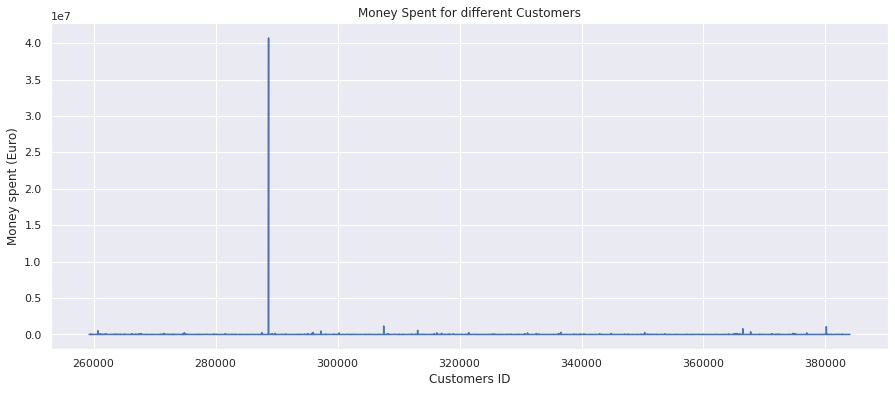

In [52]:
money_spent = df_cleaned.groupby(by=['user_id','country'], as_index=False)['total_price'].sum()

plt.subplots(figsize=(15,6))
plt.plot(money_spent.user_id, money_spent.total_price)
plt.xlabel('Customers ID')
plt.ylabel('Money spent (Euro)')
plt.title('Money Spent for different Customers')
plt.show()

### TOP 5 highest money spent

In [54]:
print('The TOP 5 customers with highest money spent...')
money_spent.sort_values(by='total_price', ascending=False).head()

The TOP 5 customers with highest money spent...


,user_id,country,total_price
1046,288687.0,United Kingdom,40710850.56
1698,307566.0,Netherlands,1160679.93
4210,380142.0,United Kingdom,1076194.08
3737,366450.0,United Kingdom,785605.83
1888,313131.0,EIRE,566959.95


In [55]:
# Add Month, Day and Hour column for some analysis
df_cleaned.insert(loc=2, column='year_month', value=df_cleaned['trans_time'].map(lambda x: 100*x.year + x.month))
df_cleaned.insert(loc=3, column='year', value=df_cleaned.trans_time.dt.year)
df_cleaned.insert(loc=4, column='month', value=df_cleaned.trans_time.dt.month)
# +1 to make Monday=1.....til Sunday=7
df_cleaned.insert(loc=5, column='day', value=(df_cleaned.trans_time.dt.dayofweek)+1)
df_cleaned.insert(loc=6, column='hour', value=df_cleaned.trans_time.dt.hour)

In [56]:
df_cleaned.head()

,user_id,trans_id,year_month,year,month,day,hour,trans_time,item_code,description,quantity,unit_price,country,quantity_canceled,total_price
0,278166.0,6355745,201902,2019,2,6,18,2019-02-02 18:20:00,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,0,70.38
1,337701.0,6283376,201812,2018,12,3,14,2018-12-26 14:36:00,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,0,10.56
2,267099.0,6385599,201902,2019,2,5,15,2019-02-15 15:15:00,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,0,64.80
3,380478.0,6044973,201806,2018,6,5,12,2018-06-22 12:44:00,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,0,5.19
5,285957.0,6307136,201901,2019,1,5,15,2019-01-11 15:20:00,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom,0,42.24


### How many orders (per month)?

In [57]:
print("Start Date: " , min(df_cleaned['trans_time']))
print("End Date: " , max(df_cleaned['trans_time']))

Start Date:  2018-02-12 09:56:00
End Date:  2019-02-20 14:20:00


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


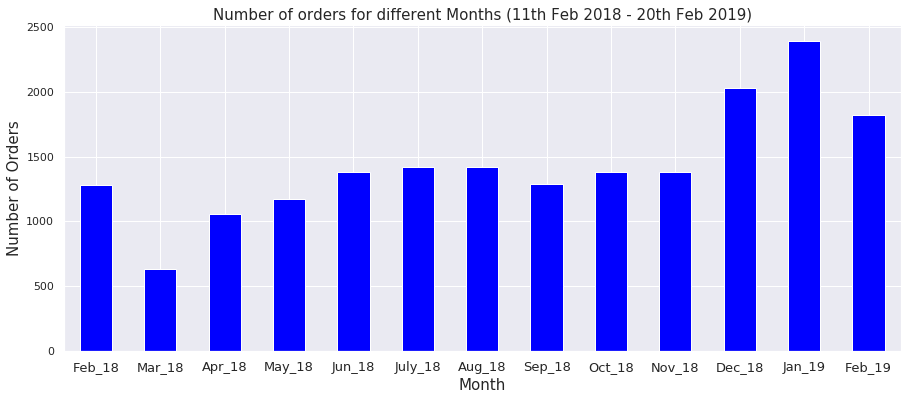

In [58]:
# Plot month wise orders...
ax = df_cleaned.groupby('trans_id')['year_month'].unique().value_counts().sort_index().plot('bar',color = "blue",figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (11th Feb 2018 - 20th Feb 2019)',fontsize=15)
ax.set_xticklabels(('Feb_18','Mar_18','Apr_18','May_18','Jun_18','July_18','Aug_18','Sep_18','Oct_18','Nov_18','Dec_18','Jan_19','Feb_19'), rotation='horizontal', fontsize=13)
plt.show()

### How many orders (per day)? 

In [59]:
# We make group of transcation for each days...
df_cleaned.groupby('trans_id')['day'].unique().value_counts().sort_index()

[1]    3480
[2]    4060
[3]    2843
[5]    2174
[6]    2877
[7]    3198
Name: day, dtype: int64

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


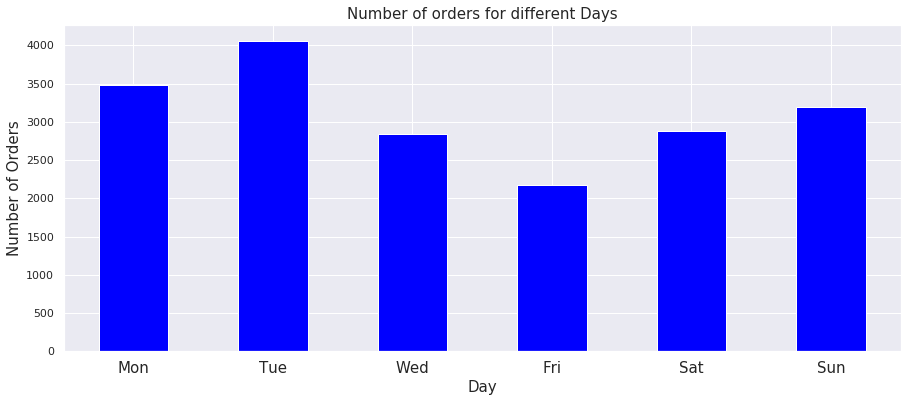

In [60]:
ax = df_cleaned.groupby('trans_id')['day'].unique().value_counts().sort_index().plot('bar',color = "blue",figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Fri','Sat','Sun'), rotation='horizontal', fontsize=15)
plt.show()

### How many orders (per hour)?

In [61]:
df_cleaned.groupby('trans_id')['hour'].unique().value_counts().iloc[:-1].sort_index()

[7]        3
[9]      223
[10]     947
[11]    1868
[12]    2018
[13]    3066
[14]    2826
[15]    2421
[16]    2270
[17]    1573
[18]     912
[19]     274
[20]     136
[21]      94
Name: hour, dtype: int64

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


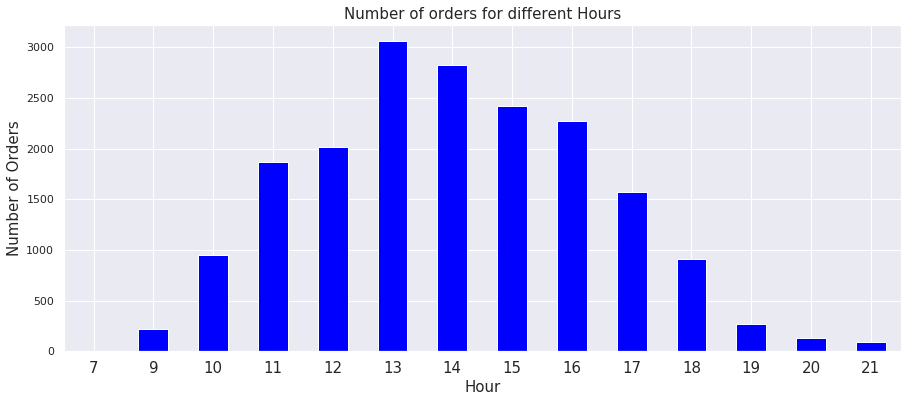

In [62]:
ax = df_cleaned.groupby('trans_id')['hour'].unique().value_counts().iloc[:-1].sort_index().plot('bar',color = "blue",figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels((7,9,10,11,12,13,14,15,16,17,18,19,20,21), rotation='horizontal', fontsize=15)
plt.show()

### How many orders for each country?

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  


With United Kingdom


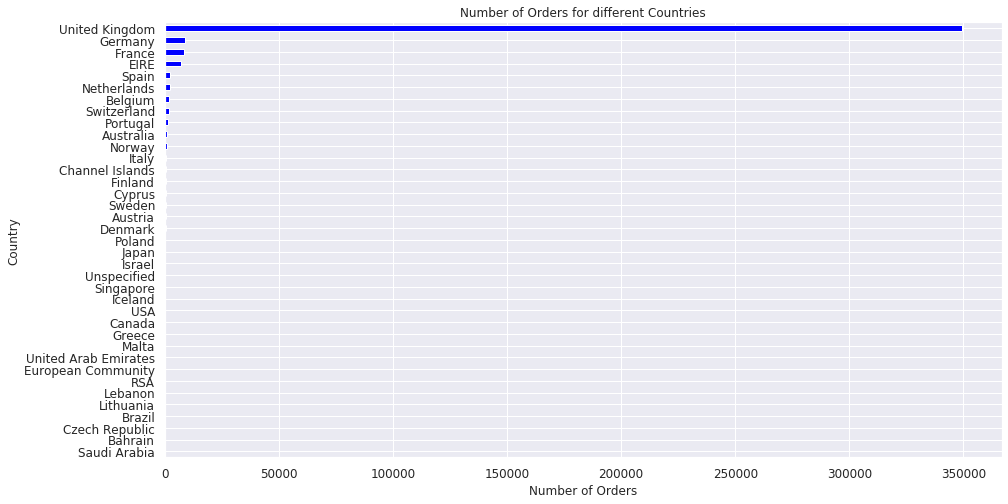

In [63]:
group_country_orders = df_cleaned.groupby('country')['trans_id'].count().sort_values()
# del group_country_orders['United Kingdom']

# plot number of unique customers in each country (with UK)
plt.subplots(figsize=(15,8))
group_country_orders.plot('barh', fontsize=12, color = "blue")
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
print("With United Kingdom")
plt.show()

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  


Without United Kingdom


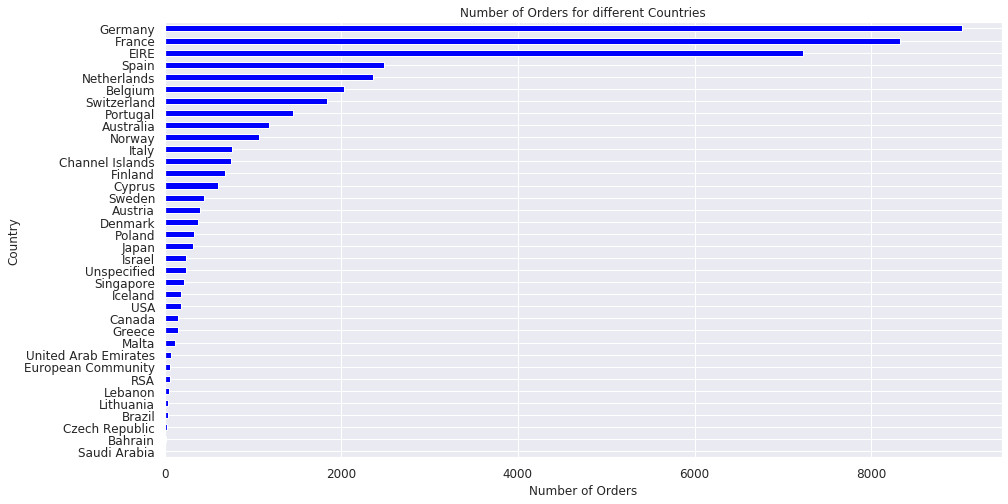

In [64]:
group_country_orders = df_cleaned.groupby('country')['trans_id'].count().sort_values()
del group_country_orders['United Kingdom']

# plot number of unique customers in each country (without UK)
plt.subplots(figsize=(15,8))
group_country_orders.plot('barh', fontsize=12, color = "blue")
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
print("Without United Kingdom")
plt.show()

### How much money spent by each country?

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """


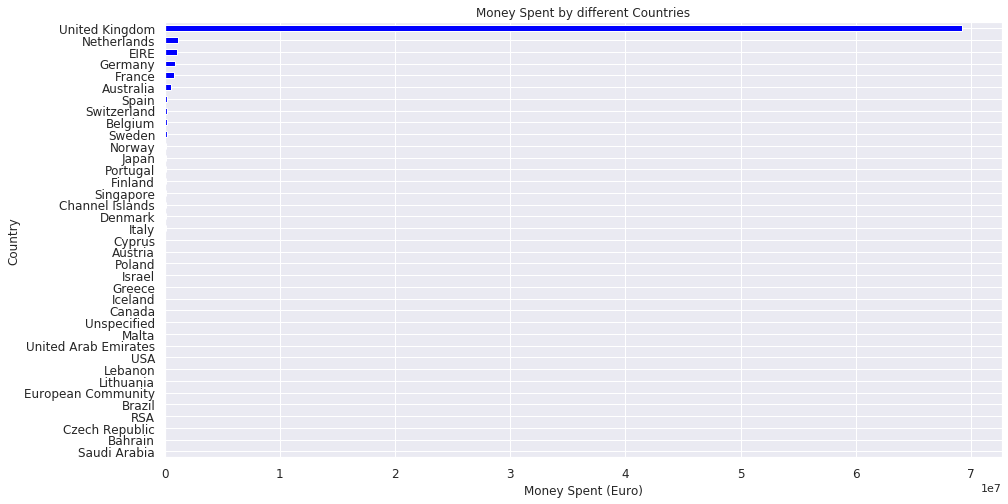

In [65]:
group_country_amount_spent = df_cleaned.groupby('country')['total_price'].sum().sort_values()

# plot total money spent by each country (with UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot('barh', fontsize=12, color = "blue")
plt.xlabel('Money Spent (Euro)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  


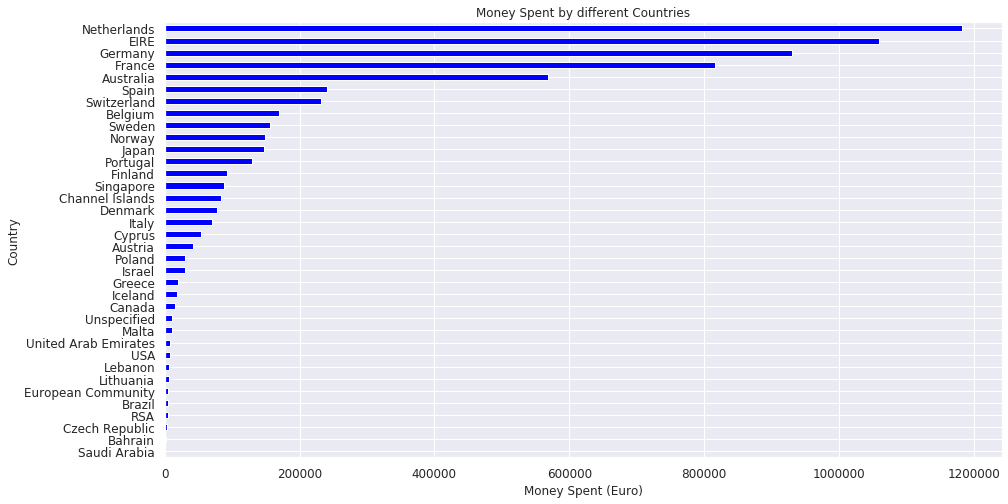

In [66]:
group_country_amount_spent = df_cleaned.groupby('country')['total_price'].sum().sort_values()
del group_country_amount_spent['United Kingdom']

# plot total money spent by each country (with UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot('barh', fontsize=12, color = "blue")
plt.xlabel('Money Spent (Euro)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

# Description variable Clustering

Description of each product(3200) is uniques and we can obtain much information about product from it. Item Code respect to that description is unique too. But we can't get information from it. So, I ignore it.

Initially I will remove some stop words, do tokenization and stamming on given description, clean text and take only meaningful word of description only.

Then I will do clustering on that part to segment items using its description only.

In [69]:
# Take only description and ignore itemcode
df_product = pd.DataFrame(df_cleaned['description'].unique()).rename(columns = {0:'description'})

In [71]:
# Include new variable total words
df_product['total_words'] = df_product['description'].str.split().str.len()

In [72]:
# Include new variable description length
df_product['desc_len'] = df_product['description'].str.len()

In [74]:
print("No. of Unique descriptions: " , len(df_product))
df_product.head()

No. of Unique descriptions:  3878


,description,total_words,desc_len
0,FAMILY ALBUM WHITE PICTURE FRAME,5,32
1,LONDON BUS COFFEE MUG,4,21
2,SET 12 COLOUR PENCILS DOLLY GIRL,6,33
3,UNION JACK FLAG LUGGAGE TAG,5,27
4,CUT GLASS T-LIGHT HOLDER OCTAGON,5,32


Below function do following operations:

1. Extract the names(proper) appearing in description
2. For each name, extract the root of the word and aggregate the set of names associated with this particular root
3. Count the number of times each root appears in the dataframe
4. When several words are listed for the same root, I consider that the keyword associated with this root is the shortest name

In [80]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                
    return category_keys, keywords_roots, keywords_select, count_keywords

In [81]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_product)

In [85]:
print("No. of Keywords in Description variable: " , len(keywords))

No. of Keywords in Description variable:  1479


count_keywords variable shows how many time each keywords occur.

In [89]:
# Here I make list of keywords and its value
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

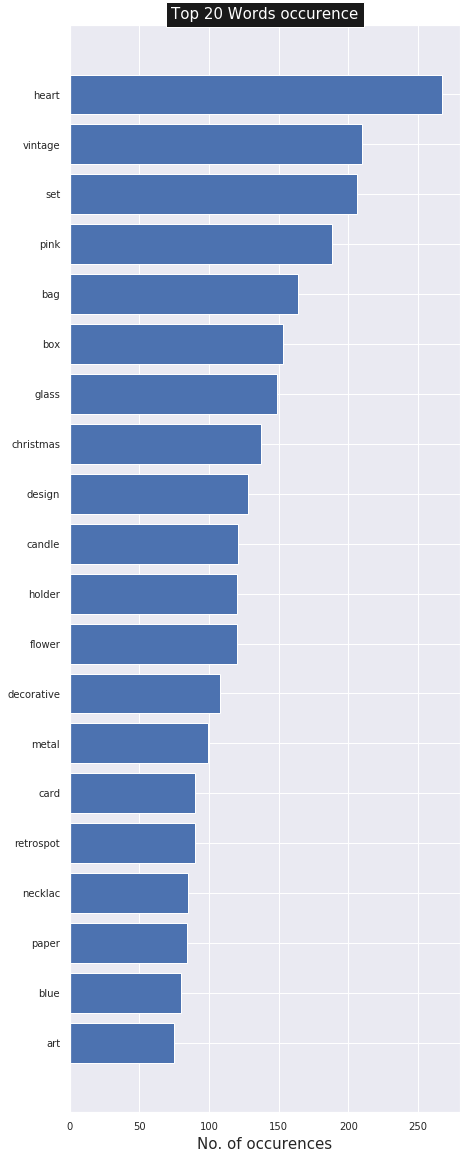

In [100]:
# Number of occurence for top 20 words
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 20))
y_axis = [i[1] for i in list_products[:20]]
x_axis = [k for k,i in enumerate(list_products[:20])]
x_label = [i[0] for i in list_products[:20]]
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.yticks(x_axis, x_label)
plt.xlabel("No. of occurences", fontsize = 15, labelpad = 5)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()


plt.title("Top 20 Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 15)
plt.show()

In [188]:
lp = df_product['description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), lp))

In [189]:
X['total_words'] = df_product['total_words']
X['desc_len'] = df_product['desc_len']

In [190]:
# This is simple Bag of Words.
X.head()

,heart,vintage,set,pink,bag,box,glass,christmas,design,candle,...,blue/green,scallop,mummy,blue/nat,z,draw,mark,peridot,total_words,desc_len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,32
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,21
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,33
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,27
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,5,32


In [191]:
# check k-mean silhouette score for diierent cluster size
matrix = X.values
for n_clusters in range(3,11):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.27003643370953107
For n_clusters = 4 The average silhouette_score is : 0.20378535777282994
For n_clusters = 5 The average silhouette_score is : 0.15918082013323834
For n_clusters = 6 The average silhouette_score is : 0.11981179213737869
For n_clusters = 7 The average silhouette_score is : 0.10610308660378685
For n_clusters = 8 The average silhouette_score is : 0.0852038236415052
For n_clusters = 9 The average silhouette_score is : 0.07066265589048369
For n_clusters = 10 The average silhouette_score is : 0.06010275041547098


Here I use silhouette score for validating cluser efficiency and i will take cluser size = 5

In [192]:
# run the loop till silhouette score is less than 0.145
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.15918082013323834


In [196]:
# These are the clusters and number of elements in each clusters
pd.Series(clusters).value_counts()

0    1134
3     948
2     853
1     664
4     279
dtype: int64

In [199]:
# Now append this cluster column in original dataframe
corresp = dict()
for key, val in zip (lp, clusters):
    corresp[key] = val 

df_cleaned['category_desc'] = df_cleaned.loc[:, 'description'].map(corresp)

In [203]:
df_cleaned.head()

,user_id,trans_id,year_month,year,month,day,hour,trans_time,item_code,description,quantity,unit_price,country,quantity_canceled,total_price,category_desc
0,278166.0,6355745,201902,2019,2,6,18,2019-02-02 18:20:00,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,0,70.38,2
1,337701.0,6283376,201812,2018,12,3,14,2018-12-26 14:36:00,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,0,10.56,1
2,267099.0,6385599,201902,2019,2,5,15,2019-02-15 15:15:00,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,0,64.80,2
3,380478.0,6044973,201806,2018,6,5,12,2018-06-22 12:44:00,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,0,5.19,3
5,285957.0,6307136,201901,2019,1,5,15,2019-01-11 15:20:00,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom,0,42.24,2


# Feature Creation from above clustering process

Now, I will make new four category(variable) which contain how much amount spent in each clusers.

In [204]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['category_desc'] == i]
    price_temp = df_temp['unit_price'] * (df_temp['quantity'] - df_temp['quantity_canceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

This is nothing but put total price into category wise columns.

In [205]:
df_cleaned.head()

,user_id,trans_id,year_month,year,month,day,hour,trans_time,item_code,description,...,unit_price,country,quantity_canceled,total_price,category_desc,categ_0,categ_1,categ_2,categ_3,categ_4
0,278166.0,6355745,201902,2019,2,6,18,2019-02-02 18:20:00,465549,FAMILY ALBUM WHITE PICTURE FRAME,...,11.73,United Kingdom,0,70.38,2,0.0,0.00,70.38,0.00,0.0
1,337701.0,6283376,201812,2018,12,3,14,2018-12-26 14:36:00,482370,LONDON BUS COFFEE MUG,...,3.52,United Kingdom,0,10.56,1,0.0,10.56,0.00,0.00,0.0
2,267099.0,6385599,201902,2019,2,5,15,2019-02-15 15:15:00,490728,SET 12 COLOUR PENCILS DOLLY GIRL,...,0.90,France,0,64.80,2,0.0,0.00,64.80,0.00,0.0
3,380478.0,6044973,201806,2018,6,5,12,2018-06-22 12:44:00,459186,UNION JACK FLAG LUGGAGE TAG,...,1.73,United Kingdom,0,5.19,3,0.0,0.00,0.00,5.19,0.0
5,285957.0,6307136,201901,2019,1,5,15,2019-01-11 15:20:00,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,...,3.52,United Kingdom,0,42.24,2,0.0,0.00,42.24,0.00,0.0




Up to now, the information related to a single order was split over several lines of the dataframe (one line per product).

I decide to collect the information related to a particular order and put in in a single entry.

Therefore I create a new dataframe. For each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [206]:
# Create new dataframe
temp = df_cleaned.groupby(by=['user_id', 'trans_id'], as_index=False)['total_price'].sum()
cart_price = temp.rename(columns = {'total_price':'cart_price'})

In [209]:
cart_price['no_of_products'] = products_per_basket['Number of Products']

In [213]:
print("No. of transactions :" , len(cart_price))
cart_price.head()

No. of transactions : 18632


,user_id,trans_id,cart_price,no_of_products
0,259266.0,5955741,0.00,1
1,259287.0,5913886,2951.52,31
2,259287.0,5964607,1971.96,29
3,259287.0,6041442,2640.96,24
4,259287.0,6118211,1587.12,18


In [214]:
# Add Category wise data of main dataframe to cart_price with same user id and transaction id
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['user_id', 'trans_id'], as_index=False)[col].sum()
    cart_price.loc[:, col] = temp

In [217]:
cart_price.head()

,user_id,trans_id,cart_price,no_of_products,categ_0,categ_1,categ_2,categ_3,categ_4
0,259266.0,5955741,0.00,1,0.00,0.00,0.00,0.00,0.00
1,259287.0,5913886,2951.52,31,1048.62,317.52,991.14,594.24,0.00
2,259287.0,5964607,1971.96,29,767.28,253.68,416.46,534.54,0.00
3,259287.0,6041442,2640.96,24,546.12,219.24,364.08,1387.20,124.32
4,259287.0,6118211,1587.12,18,562.92,492.84,70.44,357.24,103.68


Now I append mean time of each transaction into cart price

In [220]:
# Convert time into Integer
df_cleaned['trans_time'] = df_cleaned['trans_time'].astype('int64')

# Take mean time of whole transaction
temp = df_cleaned.groupby(by=['user_id', 'trans_id'], as_index=False)['trans_time'].mean()

# Covert time into datetime format again
cart_price.loc[:, 'trans_time'] = pd.to_datetime(temp['trans_time'])

In [225]:
cart_price.head()

,user_id,trans_id,cart_price,no_of_products,categ_0,categ_1,categ_2,categ_3,categ_4,trans_time
0,259266.0,5955741,0.00,1,0.00,0.00,0.00,0.00,0.00,2018-04-01 11:31:00.000000000
1,259287.0,5913886,2951.52,31,1048.62,317.52,991.14,594.24,0.00,2018-02-18 16:26:59.999998720
2,259287.0,5964607,1971.96,29,767.28,253.68,416.46,534.54,0.00,2018-04-09 16:00:00.000000000
3,259287.0,6041442,2640.96,24,546.12,219.24,364.08,1387.20,124.32,2018-06-19 12:13:00.000001024
4,259287.0,6118211,1587.12,18,562.92,492.84,70.44,357.24,103.68,2018-08-21 14:30:59.999999232


I group together the different entries that correspond to the same user. 

I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits.

In [240]:
# Make new Dataframe for transcation per users
transactions_per_user = cart_price.groupby(by=['user_id'])['cart_price'].agg(['count','min','max','mean','sum'])

# Rename count to no_of_purchase
transactions_per_user = transactions_per_user.rename(columns = {'count' : 'no_of_purchase'})

In [241]:
# Add number of products in all total visits.
transactions_per_user['no_of_products'] = cart_price.groupby(by=['user_id'])['no_of_products'].sum()
print(transactions_per_user.shape)
transactions_per_user.head()

(4339, 6)


,no_of_purchase,min,max,mean,sum,no_of_products
user_id,,,,,,
259266.0,1,0.00,0.00,0.000000,0.00,1
259287.0,7,933.84,5369.10,2554.242857,17879.70,182
259308.0,4,959.04,3712.32,1870.380000,7481.52,31
259329.0,1,7285.92,7285.92,7285.920000,7285.92,73
259350.0,1,1387.20,1387.20,1387.200000,1387.20,17


Now I will sum all the category wise amount whose user id is same and then replace amount by it's percentage.

That means each category show how much percentage of amount from it.

In [242]:
for i in range(5):
    col = 'categ_{}'.format(i)
    # Here I do precentage
    transactions_per_user.loc[:,col] = cart_price.groupby(by=['user_id'])[col].sum() / transactions_per_user['sum'] * 100

transactions_per_user.reset_index(drop = False, inplace = True)
cart_price.groupby(by=['user_id'])['categ_0'].sum()
transactions_per_user.sort_values('user_id', ascending = True)[:5]

,user_id,no_of_purchase,min,max,mean,sum,no_of_products,categ_0,categ_1,categ_2,categ_3,categ_4
0,259266.0,1,0.00,0.00,0.000000,0.00,1,NaN,NaN,NaN,NaN,NaN
1,259287.0,7,933.84,5369.10,2554.242857,17879.70,182,36.157989,16.373429,18.233527,24.963842,4.271213
2,259308.0,4,959.04,3712.32,1870.380000,7481.52,31,17.027556,15.009784,14.493312,31.277067,22.192282
3,259329.0,1,7285.92,7285.92,7285.920000,7285.92,73,22.979939,13.440444,21.967027,21.155050,20.457540
4,259350.0,1,1387.20,1387.20,1387.200000,1387.20,17,30.103806,20.916955,5.916955,28.572664,14.489619


I define two additional variables that give the number of days, since the first purchaseand the number of days since the last purchase.

In [243]:
# Find last date of transaction
last_date = cart_price['trans_time'].max().date()

# First Purchase date
# Don't have registration date in our dataset. So I use first purchase date as registration date.
first_registration = pd.DataFrame(cart_price.groupby(by=['user_id'])['trans_time'].min())
last_purchase      = pd.DataFrame(cart_price.groupby(by=['user_id'])['trans_time'].max())

# Make two functions
test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['trans_time']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['trans_time']

transactions_per_user[:5]

,user_id,no_of_purchase,min,max,mean,sum,no_of_products,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,259266.0,1,0.00,0.00,0.000000,0.00,1,NaN,NaN,NaN,NaN,NaN,325,325
1,259287.0,7,933.84,5369.10,2554.242857,17879.70,182,36.157989,16.373429,18.233527,24.963842,4.271213,2,367
2,259308.0,4,959.04,3712.32,1870.380000,7481.52,31,17.027556,15.009784,14.493312,31.277067,22.192282,75,358
3,259329.0,1,7285.92,7285.92,7285.920000,7285.92,73,22.979939,13.440444,21.967027,21.155050,20.457540,18,18
4,259350.0,1,1387.20,1387.20,1387.200000,1387.20,17,30.103806,20.916955,5.916955,28.572664,14.489619,310,310


In [263]:
# Now add new column quantity canceled into transactions
qc = pd.DataFrame(df_cleaned.groupby(by=['user_id'])['quantity_canceled'].sum() , columns= ['quantity_canceled'])
transactions_per_user = pd.merge(transactions_per_user, qc , on = 'user_id')
transactions_per_user.head()

,user_id,no_of_purchase,min,max,mean,sum,no_of_products,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,quantity_canceled
0,259266.0,1,0.00,0.00,0.000000,0.00,1,NaN,NaN,NaN,NaN,NaN,325,325,222645
1,259287.0,7,933.84,5369.10,2554.242857,17879.70,182,36.157989,16.373429,18.233527,24.963842,4.271213,2,367,0
2,259308.0,4,959.04,3712.32,1870.380000,7481.52,31,17.027556,15.009784,14.493312,31.277067,22.192282,75,358,0
3,259329.0,1,7285.92,7285.92,7285.920000,7285.92,73,22.979939,13.440444,21.967027,21.155050,20.457540,18,18,0
4,259350.0,1,1387.20,1387.20,1387.200000,1387.20,17,30.103806,20.916955,5.916955,28.572664,14.489619,310,310,0


Here I get insights of users:

1. Number of user with only one purchase.
2. Number of users with cancellation.

In [280]:
n1 = transactions_per_user[(transactions_per_user['no_of_purchase'] == 1) &  (transactions_per_user['quantity_canceled'] == 0)].shape[0]
n2 = transactions_per_user.shape[0]
print("No. of Customer with single Purchase: {} out of {} with {} %".format(n1,n2,round(n1/n2*100 , 2)))

No. of Customer with single Purchase: 1315 out of 4339 with 30.31 %


In [281]:
n1 = transactions_per_user[(transactions_per_user['sum'] == 0) & (transactions_per_user['quantity_canceled'] == 0)].shape[0]
n2 = transactions_per_user.shape[0]
print("No. of Customer with discount : {} out of {} with {} %".format(n1,n2,round(n1/n2*100 , 2)))

No. of Customer with discount : 1 out of 4339 with 0.02 %


In [284]:
n1 = transactions_per_user[(transactions_per_user['sum'] == 0) & (transactions_per_user['quantity_canceled'] != 0)].shape[0]
n2 = transactions_per_user.shape[0]
print("No. of Customer with cancellation : {} out of {} with {} %".format(n1,n2,round(n1/n2*100 , 2)))

No. of Customer with cancellation : 9 out of 4339 with 0.21 %


In [291]:
#Replace NaN with 0
transactions_per_user = transactions_per_user.fillna(0)

In [293]:
print("We have to make clusters for {} users".format(len(transactions_per_user)))

We have to make clusters for 4339 users


In [294]:
final_df = transactions_per_user.drop('user_id' , axis = 1)
final_df = final_df.values

# Standardization

In [295]:
scaler = StandardScaler()
scaler.fit(final_df)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_df = scaler.transform(final_df)

variables mean values: 
------------------------------------------------------------------------------------------
 [4.29407698e+00 1.03444275e+04 1.18059155e+04 1.09167030e+04
 1.74422203e+04 9.05333026e+01 2.67100934e+01 1.75877780e+01
 2.15213262e+01 2.55446152e+01 8.69084056e+00 9.20034570e+01
 2.22784052e+02 1.68116847e+02]


# Amount of varience by each of principal components

In [298]:
# Use Principal Component Analysis
pca = PCA()
pca.fit(scaled_df)
pca_samples = pca.transform(scaled_df)

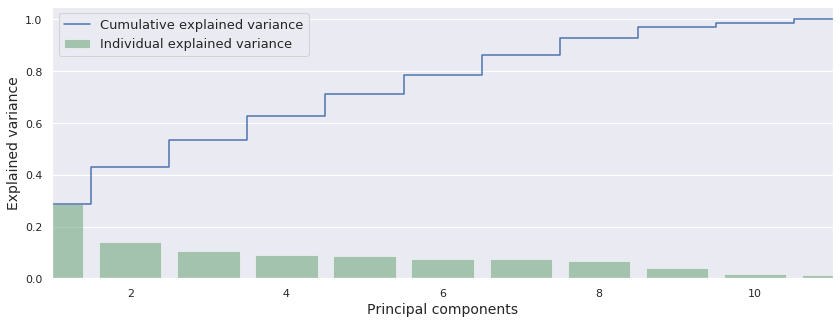

In [299]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(final_df.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='Cumulative explained variance')
sns.barplot(np.arange(1,final_df.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='Individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

# K - means Clustering for Segmentation

In [303]:
# check k-mean silhouette score for different cluster size
matrix = scaled_df
for n_clusters in range(5,16):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14967051293992828
For n_clusters = 6 The average silhouette_score is : 0.18507595070230348
For n_clusters = 7 The average silhouette_score is : 0.18902955101108085
For n_clusters = 8 The average silhouette_score is : 0.20291122930818725
For n_clusters = 9 The average silhouette_score is : 0.21124664800665297
For n_clusters = 10 The average silhouette_score is : 0.2199533092275913
For n_clusters = 11 The average silhouette_score is : 0.21844859681700718
For n_clusters = 12 The average silhouette_score is : 0.21920999904789903
For n_clusters = 13 The average silhouette_score is : 0.2277823889729226
For n_clusters = 14 The average silhouette_score is : 0.22042705771775117
For n_clusters = 15 The average silhouette_score is : 0.216128569116208


Here I use silhouette score for validation and notice that after cluster 10 score don't change too much.

So, I checked for two value of clusters 10 and 13 and it give more accurate with 10.

In [308]:
# For cluster = 10 k means
n_clusters = 10
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_df)
clusters_clients = kmeans.predict(scaled_df)
silhouette_avg = silhouette_score(scaled_df, clusters_clients)
print('Score of silhouette: ' , silhouette_avg)

Score of silhouette:  0.2199141842468101


In [310]:
# Number of Customers in each Cluster
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['No. of Customers']).T

,1,3,6,0,9,7,8,5,4,2
No. of Customers,1460,1250,739,310,272,235,62,8,2,1


# Principal Component Analysis for Final Clusters

In [311]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_df)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


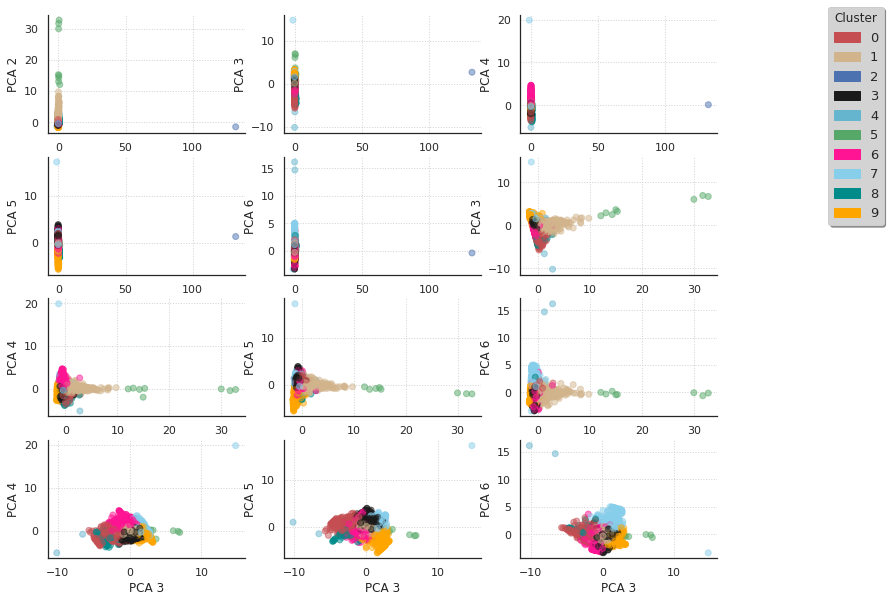

In [312]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        

comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

# Final Result and Submission

In [313]:
transactions_per_user.loc[:,'final_cluster'] = clusters_clients

In [333]:
transactions_per_user.head()

,user_id,no_of_purchase,min,max,mean,sum,no_of_products,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,quantity_canceled,final_cluster
0,259266.0,1,0.00,0.00,0.000000,0.00,1,0.000000,0.000000,0.000000,0.000000,0.000000,325,325,222645,4
1,259287.0,7,933.84,5369.10,2554.242857,17879.70,182,36.157989,16.373429,18.233527,24.963842,4.271213,2,367,0,1
2,259308.0,4,959.04,3712.32,1870.380000,7481.52,31,17.027556,15.009784,14.493312,31.277067,22.192282,75,358,0,1
3,259329.0,1,7285.92,7285.92,7285.920000,7285.92,73,22.979939,13.440444,21.967027,21.155050,20.457540,18,18,0,3
4,259350.0,1,1387.20,1387.20,1387.200000,1387.20,17,30.103806,20.916955,5.916955,28.572664,14.489619,310,310,0,6


Now for resulting Dataframe, I append two new results

1. Average of all variables grouped by clusters.
2. Total number of users in each clusters.

In [319]:
result_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(transactions_per_user[transactions_per_user['final_cluster'] == i].mean())
    test = test.T.set_index('final_cluster', drop = True)
    test['size'] = transactions_per_user[transactions_per_user['final_cluster'] == i].shape[0]
    result_df = pd.concat([result_df, test])

result_df.drop('user_id', axis = 1, inplace = True)
print('Number of customers:', result_df['size'].sum())

result_df = result_df.sort_values('sum')

Number of customers: 4339


This is Result of all clusters with average value of variables respect to specific clusters

In [322]:
result_df

,no_of_purchase,min,max,mean,sum,no_of_products,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,quantity_canceled,size
final_cluster,,,,,,,,,,,,,,,
4.0,1.500000,0.000000e+00,6.015000e+00,3.007500e+00,6.015000e+00,2.000000,0.000000,50.000000,0.000000,0.000000,0.000000,162.500000,265.000000,232815.000000,2
6.0,1.702300,1.143345e+03,1.708971e+03,1.398533e+03,2.353117e+03,32.495264,24.255651,15.906116,18.444924,33.243838,7.899094,255.004060,290.052774,44.261164,739
7.0,2.319149,7.163574e+02,1.284232e+03,9.949611e+02,2.441740e+03,21.565957,15.957173,7.439922,63.514962,13.721385,3.580023,113.970213,192.272340,36.331915,235
9.0,2.143382,9.419303e+02,2.012521e+03,1.354720e+03,2.965798e+03,19.169118,64.974235,5.713356,14.385244,11.151604,3.775561,116.860294,191.970588,13.345588,272
3.0,2.062400,1.261548e+03,1.977446e+03,1.590001e+03,3.156332e+03,53.436000,27.482961,15.489497,21.166367,27.748380,7.573845,45.864800,88.561600,13.872000,1250
0.0,2.412903,1.114924e+03,1.844587e+03,1.459526e+03,3.737015e+03,28.448387,13.811276,48.759000,10.267732,18.109359,9.119277,119.609677,207.874194,31.151613,310
8.0,2.935484,9.543218e+02,2.639240e+03,1.717707e+03,5.842792e+03,23.161290,8.760586,5.727256,6.467132,8.492945,72.200164,134.564516,217.580645,24.919355,62
1.0,8.097945,6.340557e+02,3.436218e+03,1.666175e+03,1.613403e+04,171.001370,25.457722,17.932039,21.023903,26.713733,8.928540,33.373288,316.908219,118.950000,1460
5.0,113.875000,-4.138462e+02,2.234196e+04,5.229214e+03,3.537058e+05,3976.375000,25.076741,17.913302,21.827250,23.142104,12.188619,1.250000,336.125000,2092.875000,8


In [334]:
# Submission File
subm = pd.DataFrame({
        "User_ID": transactions_per_user["user_id"],
        "Cluster": transactions_per_user["final_cluster"]
    })

subm.to_csv('submission.csv', index=False)